Data Preparation

In [84]:
import os

def scan_dataset(root_dir):
    """
    root_dir: 'data/train' or 'data/val' or 'data/test'
    Returns: list of image paths and their class names
    """
    image_paths = []
    labels = []
    
    for class_name in sorted(os.listdir(root_dir)):
        class_folder = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_folder):
            continue
        for fname in sorted(os.listdir(class_folder)):
            if fname.lower().endswith(('.jpg','.jpeg','.png')):
                image_paths.append(os.path.join(class_folder, fname))
                labels.append(class_name)
    
    return image_paths, labels


In [85]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import torch

class LandmarkDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None): # Stores image paths, labels, and transforms.
        self.image_paths = image_paths
        self.labels = labels  # None for test set
        self.transform = transform
        
    def __len__(self): # returns the number of images in the dataset.
        return len(self.image_paths)
    
    def __getitem__(self, idx): # loads and returns an image and its label (if available).
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return img, label
        else:
            return img, img_path  # return path for query images


In [86]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])


In [87]:
from torch.utils.data import DataLoader

train_paths, train_labels = scan_dataset("data/train")
val_paths, val_labels = scan_dataset("data/val")
test_paths, _ = scan_dataset("data/test")

classes = sorted(set(train_labels))
class_to_idx = {c:i for i,c in enumerate(classes)}
train_labels_idx = [class_to_idx[c] for c in train_labels]
val_labels_idx = [class_to_idx[c] for c in val_labels]

train_dataset = LandmarkDataset(train_paths, train_labels_idx, train_transform)
val_dataset = LandmarkDataset(val_paths, val_labels_idx, val_transform)
test_dataset = LandmarkDataset(test_paths, labels=None, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

DELG

# Backbone (ResNet 50) 
to extract feature maps from images / converts input images into deep feature maps.

In [88]:
import torch
import torch.nn as nn # neural network modules (e.g. Conv2d, Linear, Sequential)
import torch.nn.functional as F # activation functions and pooling
from torchvision import models # pre-trained models e.g. ResNet
import os
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms #common image transforms like resizing, cropping, normalization, and converting

In [89]:
class DELGBackbone(nn.Module):
    def __init__(self, pretrained=True):
        super(DELGBackbone, self).__init__()  
        resnet = models.resnet50(pretrained=pretrained) #Loads a ResNet-50 model from torchvision.
        self.features = nn.Sequential(*list(resnet.children())[:-2])  # Take all conv layers, remove last 2 layer avgpool & fully connected

    def forward(self, x):  # input [Batch size, 3 channel, Height, Width]
        return self.features(x)  #[B, 2048, H/32, W/32] (B=batch, 2048 channels, spatially downsampled 32x).

# GeM Pooling for global features 
Converts a feature map [B, C, H, W] into a global descriptor [B, C, 1, 1] more flexible than avg or max pooling. <br>
p = pooling parameter, p=1 → behaves like average pooling. p→∞ → behaves like max pooling.<br>
eps = small value to avoid numerical issues<br>

In [90]:
class GeM(nn.Module): 
    def __init__(self, p=3.0, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps
    
    def forward(self, x):
        #x.clamp(min=self.eps) prevents values below eps
        return F.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(1./self.p) 
        # This reduces [B, C, H, W] → [B, C, 1, 1] → can flatten to [B, C] → global descriptor for the image. for global retrieval / top-k candidate search.
        # Input: [16, 2048, 7, 7] feature maps (from ResNet backbone)
        # After GeM: [16, 2048, 1, 1] → flatten → [16, 2048]

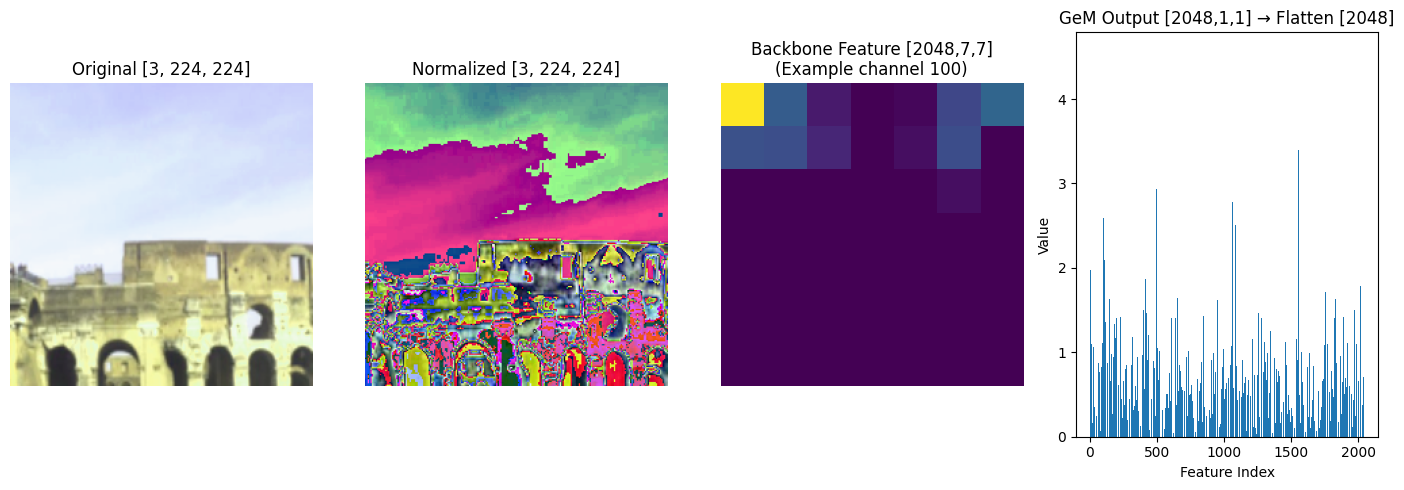

In [91]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import matplotlib.pyplot as plt

# ---- Load one normalized image from dataset ----
img, label = train_dataset[2000]

# ---- Unnormalize for display ----
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
img_unnorm = img * std + mean
img_np = img_unnorm.permute(1,2,0).numpy().clip(0,1)

# ---- ResNet-50 backbone ----
resnet = models.resnet50(pretrained=True)
backbone = nn.Sequential(*list(resnet.children())[:-2])
backbone.eval()

with torch.no_grad():
    features = backbone(img.unsqueeze(0))  # [1, 2048, 7, 7]

# Pick one example channel (say channel 100)
example_channel = features[0, 100, :, :].cpu().numpy()
example_channel = (example_channel - example_channel.min()) / (example_channel.max() - example_channel.min())  # normalize for visualization

# ---- GeM pooling ----
class GeM(nn.Module):
    def __init__(self, p=3.0, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps
    
    def forward(self, x):
        return torch.nn.functional.avg_pool2d(
            x.clamp(min=self.eps).pow(self.p),
            (x.size(-2), x.size(-1))
        ).pow(1./self.p)

gem = GeM()
with torch.no_grad():
    global_desc = gem(features)  # [1, 2048, 1, 1]
    flattened = global_desc.view(-1).cpu().numpy()  # [2048]

# ---- Visualization ----
fig, axes = plt.subplots(1, 4, figsize=(14, 5))

axes[0].imshow(img_np)
axes[0].set_title("Original [3, 224, 224]")
axes[0].axis('off')

axes[1].imshow(transforms.ToPILImage()(img))
axes[1].set_title("Normalized [3, 224, 224]")
axes[1].axis('off')

axes[2].imshow(example_channel, cmap='viridis')
axes[2].set_title("Backbone Feature [2048,7,7]\n(Example channel 100)")
axes[2].axis('off')

axes[3].bar(range(len(flattened)), flattened)
axes[3].set_title("GeM Output [2048,1,1] → Flatten [2048]")
axes[3].set_xlabel("Feature Index")
axes[3].set_ylabel("Value")

plt.tight_layout()
plt.show()


Feature shape: torch.Size([2048, 7, 7])


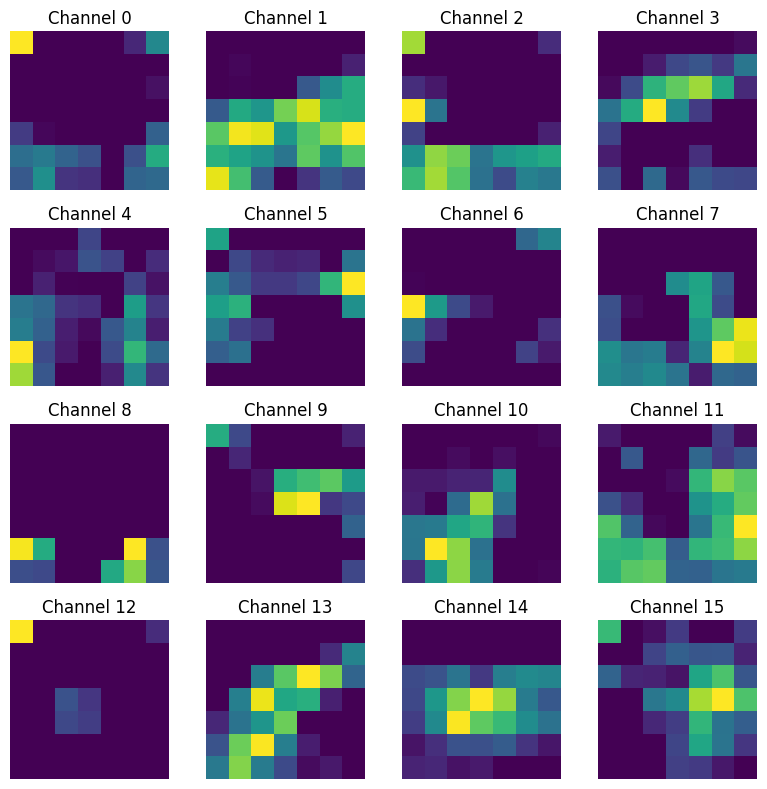

In [92]:
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
from PIL import Image

# Load backbone
resnet = models.resnet50(pretrained=True)
backbone = torch.nn.Sequential(*list(resnet.children())[:-2])
backbone.eval()

# Take one image
img, label = train_dataset[0]
with torch.no_grad():
    feats = backbone(img.unsqueeze(0))[0]  # [2048, H/32, W/32]

print("Feature shape:", feats.shape)

# Normalize for visualization
feats = (feats - feats.min()) / (feats.max() - feats.min())

# Plot first 16 channels for example
fig, axes = plt.subplots(4, 4, figsize=(8,8))
for i in range(16):
    axes[i//4, i%4].imshow(feats[i].cpu(), cmap='viridis')
    axes[i//4, i%4].set_title(f"Channel {i}")
    axes[i//4, i%4].axis('off')

plt.tight_layout()
plt.show()


Retains discriminative power: max pooling focuses on the most distinctive part; GeM softly keeps both local and global info.<br>

Avg pooled: blurred → all 7×7 reduced to one average.<br>
Max pooled: brightest value only survives.<br>
GeM pooled: in between — it weights high activations more strongly than avg but softer than max.<br>

# Attention module for local features
telling the model which spatial regions in the feature map are more important (e.g. landmark details like windows, arches, towers)

In [93]:

class AttentionModule(nn.Module):
    def __init__(self, in_channels=2048): # same as the ResNet50 backbone output channels ([B, 2048, H/32, W/32] e.g. [B, 2048, 7, 7]
        super(AttentionModule, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 512, kernel_size=1) # Reduces the channel dimension , Keeps the spatial dimension (still 7×7)
        self.conv2 = nn.Conv2d(512, 1, kernel_size=1) # Collapses 512 channels into a single attention map per image. This gives [B, 1, 7, 7]
    
    def forward(self, x):
        att = F.relu(self.conv1(x))
        att = torch.sigmoid(self.conv2(att))  # [B,1,H,W] Normalizes output between 0 and 1
        return att

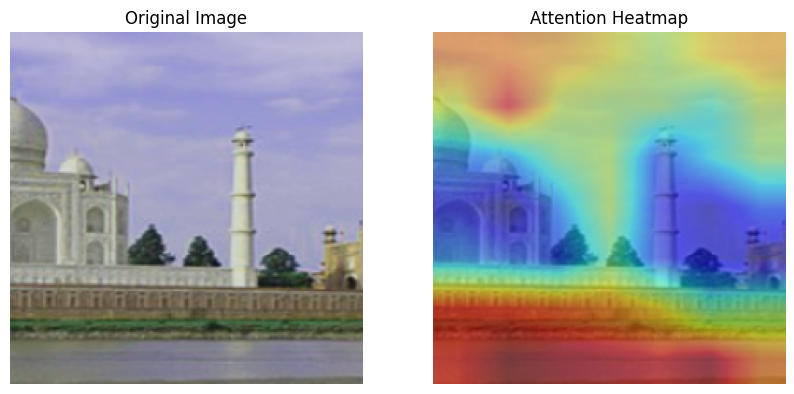

In [94]:
# ---------- Backbone (ResNet50 up to conv5_x) ----------
resnet = models.resnet50(pretrained=True)
backbone = nn.Sequential(*list(resnet.children())[:-2])
backbone.eval()

# ---------- Get one image ----------
img, label = train_dataset[2500]
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
img_unnorm = img * std + mean
img_np = img_unnorm.permute(1,2,0).numpy().clip(0,1)

img_norm_np = (img - img.min()) / (img.max() - img.min())
img_norm_np = img_norm_np.permute(1,2,0).numpy().clip(0,1)

# ---------- Forward pass ----------
att_module = AttentionModule()
att_module.eval()

with torch.no_grad():
    features = backbone(img.unsqueeze(0))   # [1, 2048, 7, 7]
    att_map = att_module(features)          # [1, 1, 7, 7]

# ---------- Resize attention map to image size ----------
att_resized = F.interpolate(att_map, size=(img_np.shape[0], img_np.shape[1]), mode='bilinear', align_corners=False)
att_resized = att_resized.squeeze().cpu().numpy()

# Normalize 0–1
att_resized = (att_resized - att_resized.min()) / (att_resized.max() - att_resized.min())

# ---------- Plot ----------
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_np)
plt.imshow(att_resized, cmap='jet', alpha=0.5)  # Overlay heatmap
plt.title("Attention Heatmap")
plt.axis('off')

plt.show()

Red = higher attention (important for landmark recognition).<br>
Blue = less important areas (like sky, road, etc.)

# DELG model

In [95]:
class DELG(nn.Module):
    def __init__(self, pretrained=True, use_global=True, use_local=True):
        super(DELG, self).__init__()
        self.backbone = DELGBackbone(pretrained) # ResNet50 conv layers
        self.gem = GeM() if use_global else None
        self.attention = AttentionModule() if use_local else None
        self.use_global = use_global # allows to switch off global or local descriptors
        self.use_local = use_local # allows to switch off global or local descriptors
    
    def forward(self, x):
        fmap = self.backbone(x)  # Output size [B,2048,H/32,W/32]
        output = {}
        
        if self.use_global: # add global descriptor (GeM pooled)
            gfeat = self.gem(fmap)  # [B,2048,1,1]
            gfeat = gfeat.view(gfeat.size(0), -1)  # flatten [B,2048]
            gfeat = F.normalize(gfeat, p=2, dim=1)  # L2 normalize (good for cosine similarity retrieval)
            output['global'] = gfeat
        
        if self.use_local: # add local descriptors with attention
            att = self.attention(fmap)  # [B,1,H,W]
            local_desc = fmap * att       # attention-weighted descriptors
            B,C,H,W = local_desc.shape
            local_desc = local_desc.view(B,C,H*W).permute(0,2,1)  # Reshape to [B,H*W,2048] each spatial location is a descriptor.
            output['local'] = {'descriptors': local_desc, 'attention': att}
        
        return output

In [96]:
img, label = train_dataset[2500]  # normalized tensor [3,H,W]
img = img.unsqueeze(0)            # add batch dimension [1,3,H,W]

# ---------- Forward pass through DELG ----------
model = DELG(pretrained=True, use_global=True, use_local=True)
model.eval()
with torch.no_grad():
    out = model(img)

# Global descriptor
global_feat = out['global']  # [1, 2048]

# Local descriptors & attention map
local_desc = out['local']['descriptors']  # [1, H*W, 2048]
att_map = out['local']['attention']        # [1,1,H,W]


print("Global descriptor shape:", global_feat.shape)
print("Local descriptors shape:", local_desc.shape)
print("Attention map shape:", att_map.shape)

Global descriptor shape: torch.Size([1, 2048])
Local descriptors shape: torch.Size([1, 49, 2048])
Attention map shape: torch.Size([1, 1, 7, 7])


# global_feat
 from GeM pooled backbone to get Global retrieval (top‑k) <br>
# att_map (where to look)
from Attention module (sigmoid) to get Importance map / heatmap<br>
# local_desc (actual position in img)
local_desc = backbone_features∗attention_map then flatten for Local matching / keypoints (top‑n)<br>

# DELG Fine-Tune

In [97]:
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


In [98]:
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import ImageFile
from DELG_Class import DELG  # your DELG implementation

# Allow loading truncated images safely
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
num_epochs = 10
learning_rate = 1e-4
num_classes = 18  # your landmark classes

# ----------------------------
# Load model and freeze local branch
# ----------------------------
model = DELG(pretrained=True, use_global=True, use_local=True).to(device)

# Freeze local descriptor (attention) weights
for param in model.attention.parameters():
    param.requires_grad = False

# Classification head for fine-tuning global features
classifier = nn.Linear(2048, num_classes).to(device)

# Loss and optimizer (only optimize global + classifier)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    list(model.backbone.parameters()) + list(model.gem.parameters()) + list(classifier.parameters()),
    lr=learning_rate
)

# ----------------------------
# Training loop
# ----------------------------
for epoch in range(num_epochs):
    model.train()
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        feats = model(imgs)['global']           # only global descriptors
        outputs = classifier(feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loop.set_postfix(loss=running_loss/total, acc=100.*correct/total)

    # ----------------------------
    # Validation
    # ----------------------------
    model.eval()
    classifier.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            feats = model(imgs)['global']
            outputs = classifier(feats)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100.*val_correct/val_total
    val_loss_avg = val_loss / val_total
    print(f"Epoch [{epoch+1}/{num_epochs}] | Validation Loss: {val_loss_avg:.4f} | Validation Accuracy: {val_acc:.2f}%\n")

# ----------------------------
# Save checkpoint
# ----------------------------
checkpoint = {
    'model_state_dict': model.state_dict(),
    'classifier_state_dict': classifier.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
    'epoch': epoch
}
torch.save(checkpoint, "delg_global_finetune_local_pretrained.pth")


Epoch 1/10: 100%|██████████| 90/90 [05:28<00:00,  3.65s/it, acc=63.5, loss=2.72]


Epoch [1/10] | Validation Loss: 2.4975 | Validation Accuracy: 88.57%



Epoch 2/10: 100%|██████████| 90/90 [05:40<00:00,  3.78s/it, acc=82.2, loss=2.45]


Epoch [2/10] | Validation Loss: 2.2999 | Validation Accuracy: 92.38%



Epoch 3/10: 100%|██████████| 90/90 [04:58<00:00,  3.32s/it, acc=85.9, loss=2.26]


Epoch [3/10] | Validation Loss: 2.0909 | Validation Accuracy: 95.27%



Epoch 4/10: 100%|██████████| 90/90 [04:59<00:00,  3.33s/it, acc=86.6, loss=2.08]


Epoch [4/10] | Validation Loss: 1.9079 | Validation Accuracy: 95.80%



Epoch 5/10: 100%|██████████| 90/90 [05:00<00:00,  3.34s/it, acc=87, loss=1.92]  


Epoch [5/10] | Validation Loss: 1.7234 | Validation Accuracy: 96.58%



Epoch 6/10: 100%|██████████| 90/90 [04:57<00:00,  3.30s/it, acc=87.4, loss=1.76]


Epoch [6/10] | Validation Loss: 1.5593 | Validation Accuracy: 96.98%



Epoch 7/10: 100%|██████████| 90/90 [04:57<00:00,  3.30s/it, acc=89.9, loss=1.6] 


Epoch [7/10] | Validation Loss: 1.4075 | Validation Accuracy: 95.80%



Epoch 8/10: 100%|██████████| 90/90 [04:58<00:00,  3.32s/it, acc=88.3, loss=1.48]


Epoch [8/10] | Validation Loss: 1.2742 | Validation Accuracy: 96.45%



Epoch 9/10: 100%|██████████| 90/90 [05:23<00:00,  3.59s/it, acc=89.9, loss=1.33]


Epoch [9/10] | Validation Loss: 1.1380 | Validation Accuracy: 96.32%



Epoch 10/10: 100%|██████████| 90/90 [05:13<00:00,  3.48s/it, acc=89.1, loss=1.23]


Epoch [10/10] | Validation Loss: 1.0044 | Validation Accuracy: 97.77%

